# 📦 Dependencies

In [1]:
!pip install deep-translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00


In [2]:

# Core
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, precision_recall_curve
)
from sklearn.svm import SVC

# XGBoost
from xgboost import XGBClassifier

# Translation
from deep_translator import GoogleTranslator

# Utilities
import joblib
import warnings
warnings.filterwarnings("ignore")


# Data Cleaning and Preprocessing 

In [3]:
def load_and_clean_dataset_auto(file_path, spam_values=None, not_spam_values=None):
    """
    Automatically load and preprocess a dataset into ['text', 'label'] (0=ham, 1=spam).
    Detects text and label columns heuristically.
    Handles CSV encoding issues automatically.
    """
    # Detect extension
    ext = os.path.splitext(file_path)[-1].lower()

    # Load file
    if ext == ".csv":
        try:
            df = pd.read_csv(file_path, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding="latin1")
    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(file_path)
    elif ext == ".json":
        try:
            df = pd.read_json(file_path, lines=True)
        except:
            df = pd.read_json(file_path)
    elif ext == ".txt":
        try:
            df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"], engine="python", encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"], engine="python", encoding="latin1")
    else:
        raise ValueError(f"Unsupported file format: {ext}")

    # Normalize column names
    df.columns = [str(c).lower() for c in df.columns]

    # Detect text column
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    if obj_cols:
        # Choose the column with longest average string length
        text_col = df[obj_cols].apply(lambda x: x.str.len().mean()).idxmax()
    else:
        # fallback: take first column
        text_col = df.columns[0]

    # Detect label column: pick column with fewest unique values excluding text_col
    possible_label_cols = [c for c in df.columns if c != text_col]
    if possible_label_cols:
        label_col = df[possible_label_cols].nunique().idxmin()
    else:
        # fallback: second column or the same as text
        label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

    # Select and rename
    df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
    df["text"] = df["text"].astype(str)

    # Default spam/ham values
    if spam_values is None:
        spam_values = ["spam", "1", 1, True, "yes", "true", "positive"]
    if not_spam_values is None:
        not_spam_values = ["ham", "0", 0, False, "no", "false", "negative", "not spam"]

    # Normalize labels
    df["label"] = df["label"].astype(str).str.lower().map(
        lambda x: 1 if x in [str(v).lower() for v in spam_values]
        else (0 if x in [str(v).lower() for v in not_spam_values] else None)
    )

    # Drop unknown labels
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(int)

    # Clean text
    def clean_text(t):
        t = t.lower()
        t = re.sub(r"http\S+|www\S+", " ", t)
        t = re.sub(r"[^a-z0-9\s]", " ", t)
        t = re.sub(r"\s+", " ", t).strip()
        return t

    df["text"] = df["text"].apply(clean_text)

    return df.reset_index(drop=True)


# Data Combination

In [4]:
# Auto-detecting function
df1 = load_and_clean_dataset_auto("/kaggle/input/email-spam-or-not-classification/spam_dataset.csv")
df2 = load_and_clean_dataset_auto("/kaggle/input/190k-spam-ham-email-dataset-for-classification/spam_Emails_data.csv")
df3 = load_and_clean_dataset_auto("/kaggle/input/email-hamspam-dataset/email_spam.csv")
df4 = load_and_clean_dataset_auto("/kaggle/input/email-spam-classification-dataset-csv/emails.csv")
df5 = load_and_clean_dataset_auto("/kaggle/input/spam-email-classification/email_classification_dataset.csv")
df6 = load_and_clean_dataset_auto("/kaggle/input/spam-email-dataset/emails.csv")
df7 = load_and_clean_dataset_auto("/kaggle/input/spam-emails/spam.csv")
df8 = load_and_clean_dataset_auto("/kaggle/input/spamemailsdataset/Spam.csv")
df9 = load_and_clean_dataset_auto("/kaggle/input/spam-filter/emails.csv")
df10 = load_and_clean_dataset_auto("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
df11 = load_and_clean_dataset_auto("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
df12 = load_and_clean_dataset_auto("/kaggle/input/email-spam-classification/email_spam.csv")
df13 = load_and_clean_dataset_auto("/kaggle/input/email-spam-or-not-classification/spam_dataset.csv")
df14 = load_and_clean_dataset_auto("/kaggle/input/maildataset/mail_data.csv")



In [5]:
# Merge into one dataset
final_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14], ignore_index=True)

print(final_df.head())
print(final_df["label"].value_counts())

                                                text  label
0  hello lonnie just wanted to touch base regardi...      0
1  congratulations you ve won a prize call us now...      1
2  you have been pre approved for a credit card w...      1
3  limited time offer act now only a few spots le...      1
4  your loan has been approved transfer funds tod...      1
label
0    148947
1    103007
Name: count, dtype: int64


In [6]:
final_df.shape

(251954, 2)

In [7]:
final_df.isna().sum()

text     0
label    0
dtype: int64

In [8]:
final_df.duplicated().sum()

35433

In [9]:
final_df = final_df.drop_duplicates()
final_df.shape

(216521, 2)

In [10]:
final_df.sample(10)

,text,label
202431,email 2081,0
37547,if legal analysis indicates that we can make a...,0
64897,this advertisement has been sent to you by the...,1
90394,homeland security investments the terror attac...,1
78003,facilities help desk please provide standing o...,0
12517,tr,1
17204,broke create came finger answer long pose desc...,1
177061,using tomcat but need to do more need to suppo...,0
50225,ok i m in we can invite cute boys and sit on t...,0
45285,writer longer got smooth eight address satisfa...,1


In [11]:
final_dff = final_df.copy()

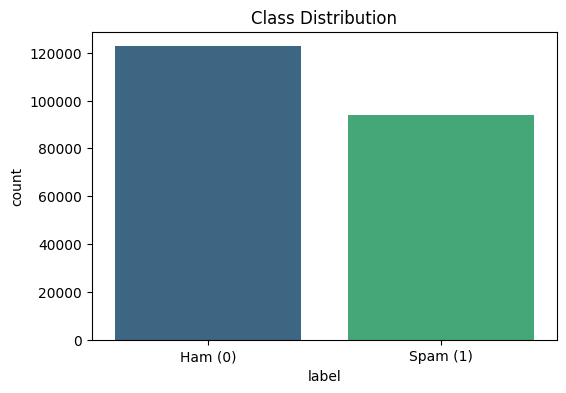

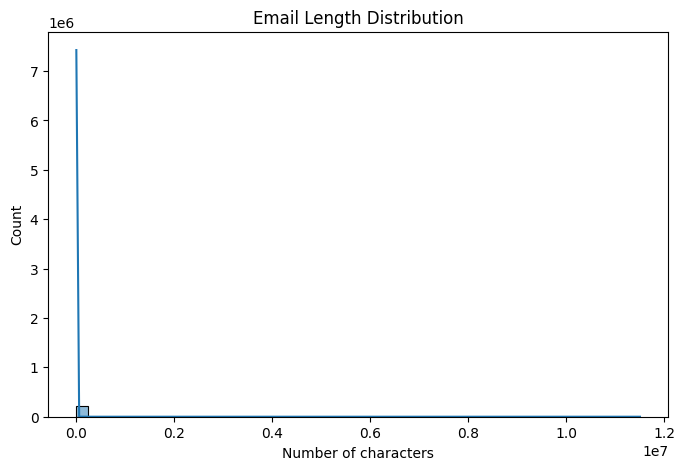

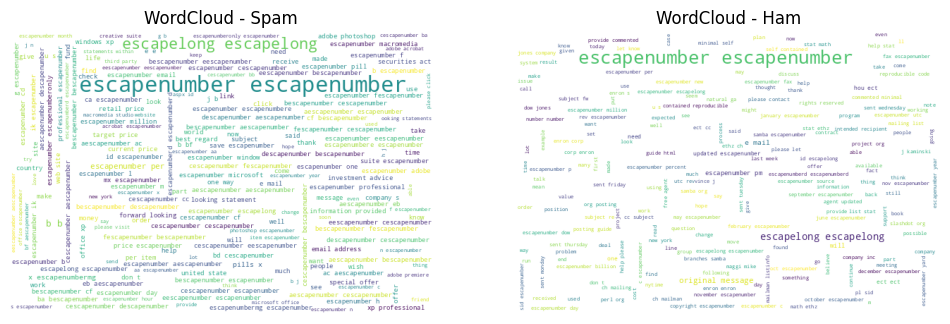

In [12]:
# ===============================
# 📊 Exploratory Data Analysis (EDA) - English Dataset
# ===============================

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=final_dff, palette="viridis")
plt.xticks([0,1], ["Ham (0)", "Spam (1)"])
plt.title("Class Distribution")
plt.show()

# Email length distribution
final_dff["length"] = final_dff["text"].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(final_dff["length"], bins=50, kde=True)
plt.title("Email Length Distribution")
plt.xlabel("Number of characters")
plt.show()

# WordClouds for spam vs ham
spam_text = " ".join(final_dff[final_dff["label"]==1]["text"])
ham_text  = " ".join(final_dff[final_dff["label"]==0]["text"])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color="white").generate(spam_text))
plt.axis("off")
plt.title("WordCloud - Spam")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color="white").generate(ham_text))
plt.axis("off")
plt.title("WordCloud - Ham")

plt.show()


In [13]:
# Check longest emails
final_dff["length"] = final_dff["text"].apply(len)
print("Max length:", final_dff["length"].max())
print(final_dff["length"].describe())

# Inspect suspiciously long ones
final_dff[final_dff["length"] > 10000].head()


Max length: 11509476
count    2.165210e+05
mean     1.647610e+03
std      2.516365e+04
min      0.000000e+00
25%      2.880000e+02
50%      7.110000e+02
75%      1.633000e+03
max      1.150948e+07
Name: length, dtype: float64


,text,label,length
1024,football commissioner escapenumber tailgate in...,0,33252
1048,enron slashes profits since 1997 by 20 partner...,0,108113
1058,fyi original message from mcleroy david smtp d...,0,11423
1154,state loses escapenumber million in power play...,0,17899
1197,be cescapenumber bescapenumber eescapenumber c...,1,16117


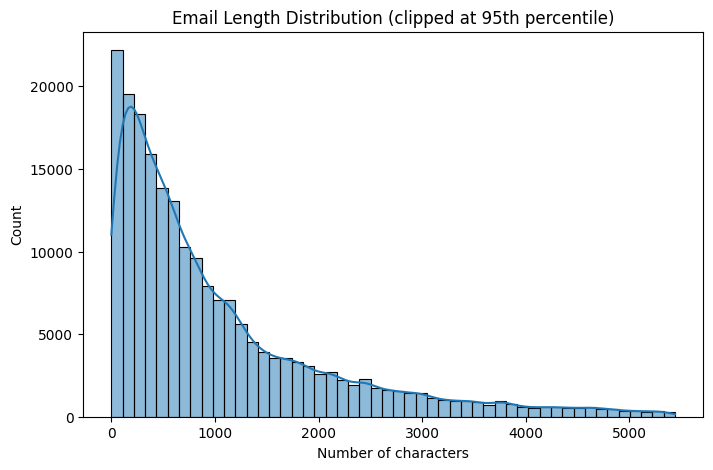

In [14]:
# Clip at 95th percentile
max_len = final_dff["length"].quantile(0.95)

plt.figure(figsize=(8,5))
sns.histplot(final_dff[final_dff["length"] < max_len]["length"], bins=50, kde=True)
plt.title("Email Length Distribution (clipped at 95th percentile)")
plt.xlabel("Number of characters")
plt.show()


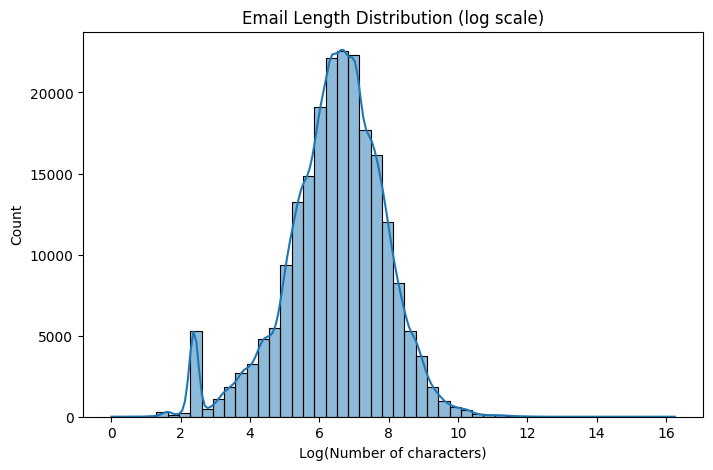

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(final_dff["length"]), bins=50, kde=True)
plt.title("Email Length Distribution (log scale)")
plt.xlabel("Log(Number of characters)")
plt.show()


# Data Slicing

In [16]:


# Shuffle indices
indices = np.arange(len(final_dff))
np.random.shuffle(indices)

# Reserve 20% as hold-out
holdout_size = int(0.2 * len(final_dff))
holdout_idx = indices[:holdout_size]
train_idx   = indices[holdout_size:]

# Split into hidden test (hold-out) and training pool
df_holdout   = final_dff.iloc[holdout_idx]
df_train_all = final_dff.iloc[train_idx]


In [17]:
df_train_all.shape

(173217, 3)

# Data Visualization

Label counts:
 label
0    98179
1    75038
Name: count, dtype: int64


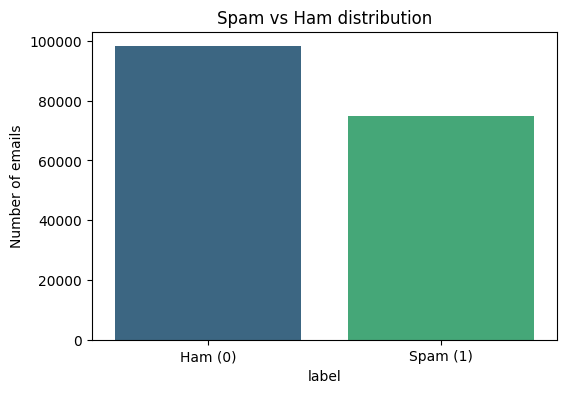

Percentage distribution:
 label
0    56.68
1    43.32
Name: count, dtype: float64


In [18]:


# Count of labels
label_counts = df_train_all['label'].value_counts()

print("Label counts:\n", label_counts)

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of emails")
plt.title("Spam vs Ham distribution")
plt.show()

# Optional: percentage
percentages = (label_counts / label_counts.sum() * 100).round(2)
print("Percentage distribution:\n", percentages)


# Over Sampling

In [19]:
import numpy as np

# Separate classes
df_ham = df_train_all[df_train_all['label'] == 0]
df_spam = df_train_all[df_train_all['label'] == 1]

# Find how many to duplicate
if len(df_ham) > len(df_spam):
    diff = len(df_ham) - len(df_spam)
    df_spam_oversampled = pd.concat([df_spam, df_spam.sample(diff, replace=True, random_state=42)])
    df_balanced = pd.concat([df_ham, df_spam_oversampled])
else:
    diff = len(df_spam) - len(df_ham)
    df_ham_oversampled = pd.concat([df_ham, df_ham.sample(diff, replace=True, random_state=42)])
    df_balanced = pd.concat([df_ham_oversampled, df_spam])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
new_counts = df_balanced['label'].value_counts()
new_percent = (new_counts / new_counts.sum() * 100).round(2)
print("Balanced label counts:\n", new_counts)
print("Balanced percentage distribution:\n", new_percent)


Balanced label counts:
 label
1    98179
0    98179
Name: count, dtype: int64
Balanced percentage distribution:
 label
1    50.0
0    50.0
Name: count, dtype: float64


In [20]:
# from transformers import MarianMTModel, MarianTokenizer
# import torch
# from tqdm import tqdm

# # Load English → Arabic translation model
# model_name = "Helsinki-NLP/opus-mt-en-ar"
# tokenizer = MarianTokenizer.from_pretrained(model_name)
# model = MarianMTModel.from_pretrained(model_name)

# # Use GPU if available
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = model.to(device)

# print(f"✅ Using device: {device}")


In [21]:
# def translate_batch(texts, max_length=512):
#     """
#     Translate a list of English texts into Arabic.
#     Handles batching to speed up translation.
#     """
#     inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
#     translated = model.generate(**inputs, max_length=max_length)
#     return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]


# def translate_dataset_hf(df, batch_size=64):
#     """
#     Translate entire dataset using Hugging Face model with progress bar.
#     """
#     translated_texts = []
#     total_batches = (len(df) // batch_size) + 1
    
#     for i in tqdm(range(0, len(df), batch_size), 
#                   total=total_batches, 
#                   desc="Translating", 
#                   unit="batch"):
#         batch = df["text"].iloc[i:i+batch_size].tolist()
#         try:
#             translated_batch = translate_batch(batch)
#         except Exception as e:
#             print(f"⚠️ Error on batch {i}: {e}")
#             translated_batch = ["" for _ in batch]
#         translated_texts.extend(translated_batch)
    
#     return translated_texts



In [22]:
# final_df_arabic = final_df.copy()
# final_df_arabic["text"] = translate_dataset_hf(final_df, batch_size=64)

# final_df_arabic.to_csv("/kaggle/working/final_df_arabic.csv", index=False)
# print("✅ Arabic dataset saved as final_df_arabic.csv")


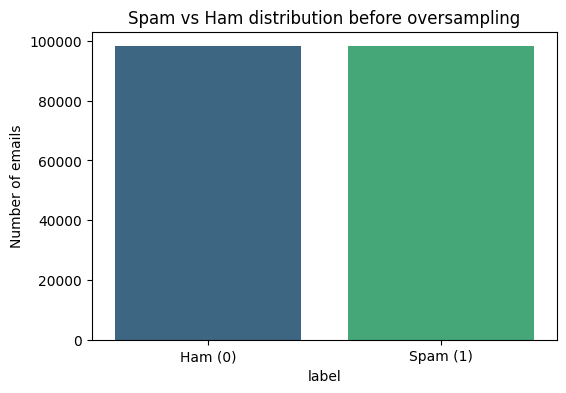

In [23]:
# Original label distribution
label_counts = df_balanced['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of emails")
plt.title("Spam vs Ham distribution before oversampling")
plt.show()


In [24]:
df_balanced.head(10)

,text,label,length
0,hello vlgr professi 0 nal 1 88 per dose vlgr s...,1,547
1,excellent erection prolonged effect no prescri...,1,232
2,attached is the gulf south oba with the follow...,0,638
3,subject german text corpora noun taxonomy dear...,0,335
4,good morning your lescapenumberan request xst ...,1,412
5,debra please disregard e mail sent phillips ga...,0,529
6,dear customer this is the letter from the cana...,1,574
7,have you ever dreamt to have a very hard penis...,1,363
8,email 4964,0,10
9,original message green tonya mailto tgreen nov...,0,820


# Vectorization

In [25]:
# Features and labels
X_text = df_balanced['text']
y = df_balanced['label']

# Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print("Vectorization done. Train shape:", X_train.shape)

Vectorization done. Train shape: (157086, 5000)


## XG

In [26]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [27]:
# Predictions
y_pred_xgb = xgb_model.predict(X_train)

# Evaluation
print("XGB Metrics:")
print("Accuracy:", accuracy_score(y_train, y_pred_xgb))
print("Precision:", precision_score(y_train, y_pred_xgb))
print("Recall:", recall_score(y_train, y_pred_xgb))
print("F1 Score:", f1_score(y_train, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_xgb))

XGB Metrics:
Accuracy: 0.9683230841704544
Precision: 0.9516471642744005
Recall: 0.9867843092318858
F1 Score: 0.9688972785118699
Confusion Matrix:
 [[74605  3938]
 [ 1038 77505]]


In [28]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Metrics:
Accuracy: 0.9617539213689142
Precision: 0.9445043631728601
Recall: 0.9811570584640457
F1 Score: 0.9624818903931659
Confusion Matrix:
 [[18504  1132]
 [  370 19266]]


In [29]:
# # ===============================
# # 🤖 Train XGBoost on Arabic Dataset
# # ===============================

# # Features & labels
# X_text_ar = arabic_final_df["text"]
# y_ar = arabic_final_df["label"]

# # Train-test split
# X_train_ar, X_test_ar, y_train_ar, y_test_ar = train_test_split(
#     X_text_ar, y_ar, test_size=0.2, random_state=42, stratify=y_ar
# )

# # Vectorizer
# vectorizer_ar = TfidfVectorizer(max_features=5000)
# X_train_ar_vec = vectorizer_ar.fit_transform(X_train_ar)
# X_test_ar_vec = vectorizer_ar.transform(X_test_ar)

# # Model
# xgb_model_ar = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
# xgb_model_ar.fit(X_train_ar_vec, y_train_ar)

# # Evaluation
# y_pred_ar = xgb_model_ar.predict(X_test_ar_vec)
# print("Arabic XGBoost Metrics:")
# print("Accuracy:", accuracy_score(y_test_ar, y_pred_ar))
# print("Precision:", precision_score(y_test_ar, y_pred_ar))
# print("Recall:", recall_score(y_test_ar, y_pred_ar))
# print("F1 Score:", f1_score(y_test_ar, y_pred_ar))

# # Save Arabic model & vectorizer
# joblib.dump(xgb_model_ar, "/kaggle/working/xgb_model_ar.pkl")
# joblib.dump(vectorizer_ar, "/kaggle/working/tfidf_vectorizer_ar.pkl")
# print("Arabic model & vectorizer saved!")


# Evaluation Phase

In [30]:
X_test_final = vectorizer.transform(df_holdout['text'])
y_test_final = df_holdout['label']


In [31]:
y_pred_xgb_test = xgb_model.predict(X_test_final)

print("XGBoost on new test data:")
print("Accuracy:", accuracy_score(y_test_final, y_pred_xgb_test))
print("Precision:", precision_score(y_test_final, y_pred_xgb_test))
print("Recall:", recall_score(y_test_final, y_pred_xgb_test))
print("F1 Score:", f1_score(y_test_final, y_pred_xgb_test))
print("Confusion Matrix:\n", confusion_matrix(y_test_final, y_pred_xgb_test))


XGBoost on new test data:
Accuracy: 0.9572556807685202
Precision: 0.9284094916620484
Recall: 0.9771980061512355
F1 Score: 0.9521791923941406
Confusion Matrix:
 [[23025  1421]
 [  430 18428]]


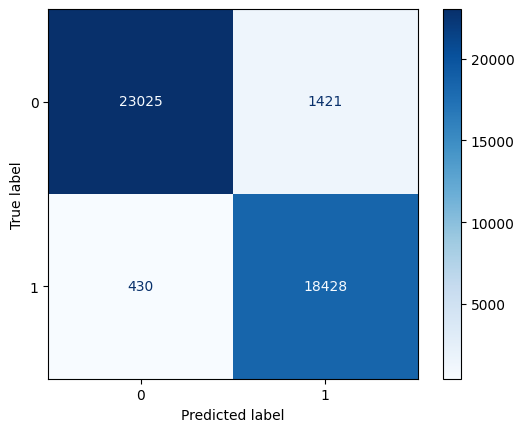

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_final, y_pred_xgb_test)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Optional: color map


In [33]:
import joblib
final_dff.to_csv("/kaggle/working/final_dff.csv", index=False)
print("Original dataset saved as final_dff.csv")


# Save Models
joblib.dump(xgb_model, "/kaggle/working/xgb_model.pkl")
print("XGBoost model saved as xgb_model.pkl")

 #Save Vectorizer
joblib.dump(vectorizer, "/kaggle/working/tfidf_vectorizer.pkl")
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")


Original dataset saved as final_dff.csv
XGBoost model saved as xgb_model.pkl
TF-IDF vectorizer saved as tfidf_vectorizer.pkl


In [34]:
# Approximate sample size in rows
# (since exact MB depends on number of columns & text length)
sample_fraction = 24 * 1024 * 1024 / final_dff.memory_usage(deep=True).sum()

# Take random sample
df_sample = final_dff.sample(frac=sample_fraction, random_state=42)

# Save to new CSV (~24 MB)
df_sample.to_csv("sample_24mb.csv", index=False)

In [35]:
from IPython.display import FileLink

# Make a clickable download link in Kaggle notebook
FileLink("sample_24mb.csv")

/kaggle/working/sample_24mb.csv